<a href="https://colab.research.google.com/github/LeandroJorquera/synthetic_L1/blob/main/emb_visualization_sklearn_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm
import pickle
#import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [2]:
def load_and_reformat(path_emb, path_labels):
    """Load emb and counts df and reformatting to make them suitable for merge"""
    # Load and reformat embeddings from pickle file
    emb_input = pd.read_pickle(path_emb)
        
    reformatted_emb = {}
    for k, v in emb_input.items():
        new_k = k.replace('-', '_')
        v = v
        reformatted_emb[new_k] = v

    # Load and reformat labels df
    labels = pd.read_csv(path_labels)
    
    reformatted_labels_dict = {}
    counts = labels['Non_redundant']
    names = labels['ID']
    taxa = labels['Taxonomy']
    prot_len = labels['prot_len']
    for i in range(len(labels)):
        cn = counts[i]
        ID = names[i]
        species = taxa[i]
        protein_length = prot_len[i]
        not_dash = ID.replace('-', '_')
        clean = not_dash.replace('.', '_')
        reformatted_labels_dict[clean] = cn, species, protein_length

    a = pd.DataFrame.from_dict(reformatted_labels_dict, orient='index')
    reformatted_labels = a.reset_index()
    reformatted_labels.columns = ['ID','Non_redundant','Taxonomy', 'prot_len']
    
    # Combine embeddings and ORF2 counts
    matrix_inverted = pd.DataFrame(reformatted_emb)
    a = matrix_inverted.transpose()
    b = a.reset_index()
    matrix = b.rename(columns={'index':'ID'})
    
    return reformatted_emb, reformatted_labels, matrix


def add_labels(adata, matched_labels):
    """Including counts information in emb matrix"""
    ID_embeddings = pd.DataFrame(matched_emb.index)
    ID_embeddings.columns = ["ID"]
    embeddings_labelled = pd.merge(ID_embeddings, matched_labels)
    embeddings_labelled.columns = ['ID', 'Non_redundant', 'Taxonomy', 'prot_len']
    #assert all(ID_embeddings.index == ID_embeddings_with_counts["ID"])
    #adata.obs["ORF_all_counts"] = ID_embeddings_with_counts["All"].values
    adata.obs["Non_redundant"] = pd.Categorical(embeddings_labelled["Non_redundant"].values)
    adata.obs["Taxonomy"] = pd.Categorical(embeddings_labelled["Taxonomy"].values)
    adata.obs["prot_len"] = pd.Categorical(embeddings_labelled["prot_lenz"].values)

def dimensionality_reduction(adata, method):
    """Define a function to run dimensionality reduction and visualize"""
    
    # Set up color gradient for labels (labels are stored in a column called "Non_redundant")
    counts_colors = np.linspace(0, 1, len(np.unique(adata.obs["Non_redundant"])))
    counts_cmap = plt.cm.get_cmap("inferno")
    counts_color_dict = dict(zip(np.unique(adata.obs["Non_redundant"]), counts_cmap(counts_colors))) 
    taxa_colors = np.linspace(0, 1, len(np.unique(adata.obs["taxa"])))
    taxa_cmap = plt.cm.get_cmap("viridis")
    taxa_color_dict = dict(zip(np.unique(adata.obs["taxa"]), taxa_cmap(taxa_colors)))
    
    # Scale data (do it only once)
    sc.pp.scale(adata)
    
    if method == "pca":
        # Run PCA
        sc.tl.pca(adata, svd_solver='arpack')
        # Define graph format and color code 
        fig, ax = plt.subplots(figsize=(6, 6))  
        sm = matplotlib.cm.ScalarMappable(norm=plt.Normalize(vmin=min(adata.obs["Non_redundant"]), vmax=max(adata.obs["Non_redundant"])), cmap=counts_cmap)
        sm.set_array([])
        # Generate PCA
        sc.pl.pca(adata, annotate_var_explained=True, color="Non_redundant", size=75, 
                  ax=ax, show=False, palette=counts_color_dict, legend_loc=None)   # palette=counts_color_dict to color dots // save = True
        cbar = plt.colorbar(sm, fraction=0.046, pad=0.04)    # modify color bar size and position
        cbar.ax.set_ylabel("Non_redundant_counts", rotation=270, labelpad=15)  # set label legend
        plt.show()
        
    elif method == "umap":
        # Run PCA first to select PCs for UMAP (RUN THIS BEFORE UMAP!!)
            #sc.tl.pca(adata, n_comps=21)
            #sc.pl.pca_variance_ratio(adata, log=True)
        # Define graph format and color code 
        fig, ax = plt.subplots(figsize=(6, 6))  
        sm = matplotlib.cm.ScalarMappable(norm=plt.Normalize(vmin=min(adata.obs["Non_redundant"]), vmax=max(adata.obs["Non_redundant"])), cmap=counts_cmap)
        sm.set_array([])
        # Generates UMAP
        sc.pp.neighbors(adata, n_neighbors=20, n_pcs=7)
        sc.tl.umap(adata)
        # Visualize UMAP results
        sc.pl.umap(adata, color='Non_redundant', size=75, 
                    ax=ax, show=False, legend_loc=None, palette=counts_color_dict) # legend_loc=None: Do not show all dots in the legend
        cbar = plt.colorbar(sm, fraction=0.046, pad=0.04)    # modify color bar size and position
        cbar.ax.set_ylabel("Non_redundant_counts", rotation=270, labelpad=15)  # set label legend
        plt.show()
        #palette=counts_color_dict
    elif method == "tsne":
        # Apply t-SNE to adata
        sc.tl.tsne(adata)
        # Define color code 
        sm = matplotlib.cm.ScalarMappable(norm=plt.Normalize(vmin=min(adata.obs["Non_redundant"]), vmax=max(adata.obs["Non_redundant"])), cmap=counts_cmap)
        sm.set_array([])
        #cbar = plt.colorbar(sm, fraction=0.046, pad=0.04)    # modify color bar size and position
        #cbar.ax.set_ylabel("Non_redundant_counts", rotation=270, labelpad=15)  # set label legend
        # plot t-SNE results
        sc.pl.tsne(adata, color="Non_redundant", size=75, 
                    show=False, palette=counts_color_dict, legend_loc=None) 
    else:
        print("Invalid method selected. Please choose from 'pca', 'umap', or 'tsne'.")

**Read dataset, labels and cleaning**

In [3]:
# -- Read pickle file containing embeddings and reformat to remove dash that block merge
path_emb = '/content/embeddings_v2.pickle'
path_labels = '/content/labels.csv'

reformat = load_and_reformat(path_emb, path_labels)

In [4]:
reformatted_emb = reformat[0]
reformatted_labels = reformat[1]
matrix = reformat[2]

**Add labels to dataset**

In [5]:
# -- Matching datasets
labelled_embs = pd.merge(matrix, reformatted_labels)

In [6]:
# -- Removing ID and labels column for reduction
X = labelled_embs.drop(columns=['ID','Non_redundant','Taxonomy', 'prot_len'])

**Apply PCA to data**

In [7]:
# -- Standardize (normalizeb) features
StandardScaler().fit_transform(X)

array([[-1.0456562 , -0.01590084,  1.7395872 , ...,  0.18787263,
         5.4501486 ,  7.844639  ],
       [ 0.2168487 ,  0.27226752,  0.5837907 , ...,  0.7832075 ,
        -0.42775145,  0.42548388],
       [-0.69285566, -2.221164  , -2.3758485 , ..., -1.4502207 ,
         1.0896281 , -0.68639296],
       ...,
       [-0.5735792 , -1.6218911 , -2.006888  , ...,  0.6868362 ,
         1.2907741 ,  0.8732931 ],
       [ 0.98456126, -0.88599616, -1.6793743 , ..., -2.5431318 ,
         0.31335208,  1.1611097 ],
       [ 0.90711355,  0.67089975,  0.8251261 , ...,  0.8534847 ,
        -0.34337106, -0.560835  ]], dtype=float32)

In [8]:
X.shape

(712, 1024)

In [9]:
# -- Define PCA reduction and apply on normalize data
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)
X_reduced_df = pd.DataFrame(data=X_reduced, columns=['PC1', 'PC2']) # create df with components weights

In [81]:
pca.explained_variance_ratio_

array([0.65864176, 0.08105066], dtype=float32)

In [55]:
# Counts

#counts_colors = np.linspace(0, 1, len(np.unique(labelled_embs["Non_redundant"])))
#counts_color_dict = dict(zip(np.unique(labelled_embs["Non_redundant"]), counts_cmap(label_colors)))
# Protein length

#len_colors = np.linspace(0, 1, len(np.unique(labelled_embs["prot_len"])))
#len_color_dict = dict(zip(np.unique(labelled_embs["prot_len"]), len_cmap(len_colors)))

In [ ]:
# -- Define color maps for counts and protein length
counts_cmap = matplotlib.colormaps["inferno"]
len_cmap = matplotlib.colormaps["viridis"]

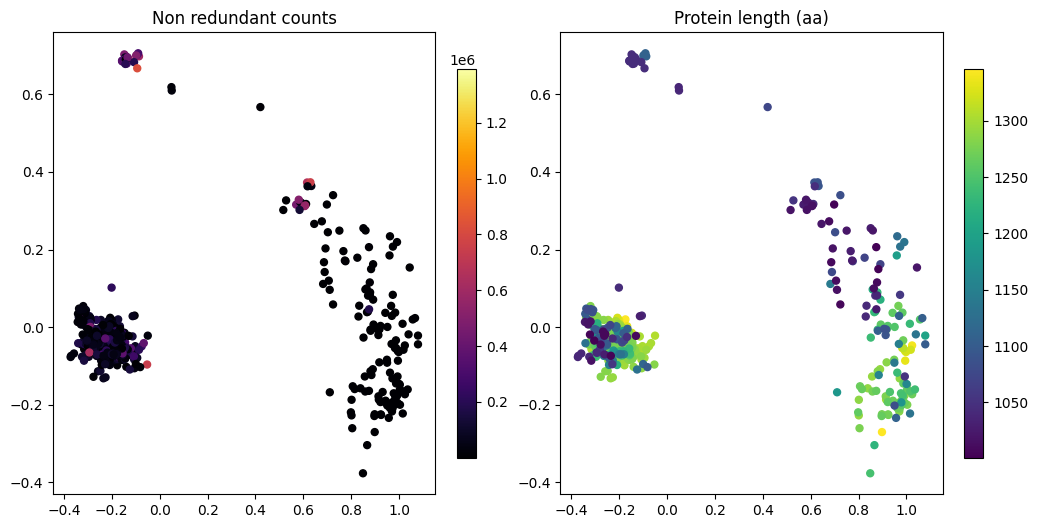

In [62]:
# -- Plot PCA results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6)) 

sm = matplotlib.cm.ScalarMappable(norm=plt.Normalize(vmin=min(labelled_embs["Non_redundant"]), vmax=max(labelled_embs["Non_redundant"])), cmap=counts_cmap)
sm.set_array([])
sm2 = matplotlib.cm.ScalarMappable(norm=plt.Normalize(vmin=min(labelled_embs["prot_len"]), vmax=max(labelled_embs["prot_len"])), cmap=len_cmap)
sm2.set_array([])

# -- label counts
ax1.scatter(X_reduced[:, 0], X_reduced[:, 1], s=25, c=labelled_embs["Non_redundant"], cmap =counts_cmap)
cbar = plt.colorbar(sm, ax=ax1, fraction=0.046)  # modify color bar size and position
ax1.set_title('Non redundant counts')

# -- labe protein length
ax2.scatter(X_reduced[:, 0], X_reduced[:, 1], s=25, c=labelled_embs["prot_len"]) 
cbar2 = plt.colorbar(sm2, ax=ax2, fraction=0.046)   # modify color bar size and position
ax2.set_title('Protein length (aa)')

plt.show()

**Plot PCA results**

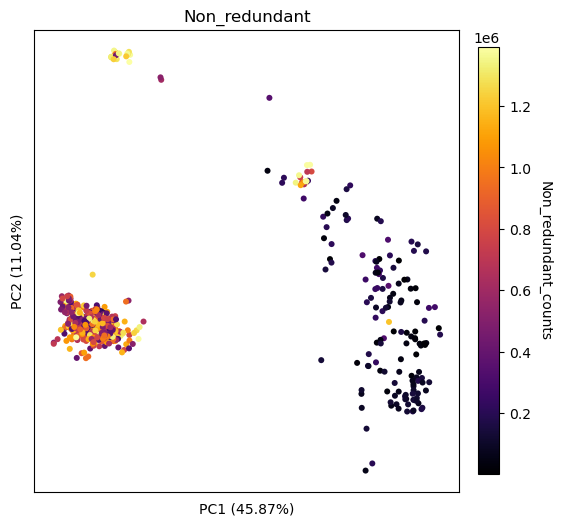

In [ ]:
dimensionality_reduction(adata, method = 'pca')

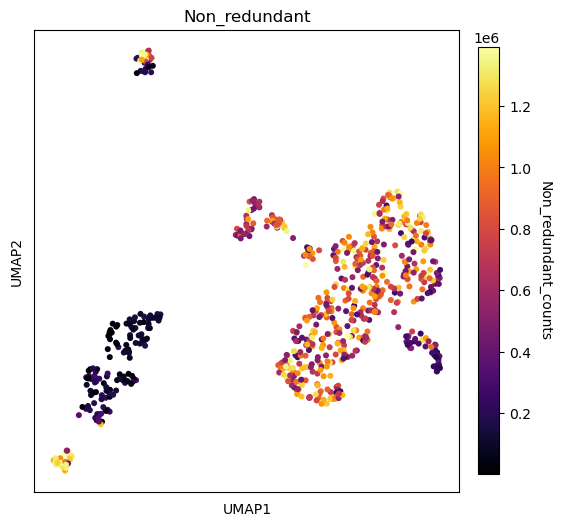

In [ ]:
dimensionality_reduction(adata, method = 'umap')

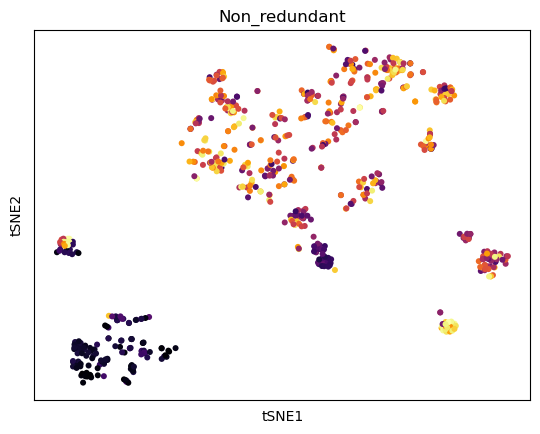

In [ ]:
dimensionality_reduction(adata, method ='tsne')